In [1]:
!pip install mplcyberpunk

In [2]:
import kagglehub
import polars as pl
import polars.selectors as cs
import numpy as np

from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

plt.style.use('cyberpunk')

2025-08-20 06:56:55.170359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755673015.498323      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755673015.597941      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pl.read_csv('/kaggle/input/online-furniture-orders-delivery-and-assembly-2025/online_furniture_retailer.csv')

In [4]:
df = df.with_columns(cs.numeric().fill_null(strategy='mean')).drop(['brand', 'order_id', 'customer_id'])
df.head()

product_category,product_subcategory,delivery_status,assembly_service_requested,payment_method,product_price,shipping_cost,assembly_cost,total_amount,delivery_window_days,customer_rating
str,str,str,bool,str,f64,f64,f64,f64,i64,f64
"""Outdoor""","""Patio Set""","""Failed Delivery""",true,"""Credit Card""",191.27,45.63,86.82,323.72,11,3.2
"""Living Room""","""Sofa""","""Cancelled""",true,"""Apple Pay""",702.87,52.65,183.07,938.59,10,4.5
"""Dining Room""","""Bar Stool""","""Delivered""",false,"""Cash on Delivery""",395.41,96.79,0.0,492.2,2,3.059047
"""Dining Room""","""China Cabinet""","""Pending""",false,"""Google Pay""",602.59,0.0,0.0,602.59,9,3.059047
"""Dining Room""","""China Cabinet""","""Pending""",true,"""Apple Pay""",1782.36,69.23,41.53,1893.12,13,1.3


In [5]:
x = df
y = x.drop_in_place('product_category')

mapping = {}
for idx, val in enumerate(y.unique()):
    mapping[val] = idx

y = y.replace_strict(mapping)

In [6]:
num_feats = x.select(cs.numeric())
cat_feats = x.select(cs.string())

In [7]:
scaler = MinMaxScaler()

cat_feats = cat_feats.to_dummies().cast(pl.Float64)
num_feats = pl.DataFrame(scaler.fit_transform(num_feats))
x = pl.concat([num_feats, cat_feats], how="horizontal")

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [9]:
inputs = layers.Input(shape=(x_train.shape[1],))
x = layers.Dense(units=128, activation='relu')(inputs)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dense(units=32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(units=len(mapping), activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

2025-08-20 06:57:17.108577: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,190 (67.15 KB)

 Trainable params: 17,126 (66.90 KB)

 Non-trainable params: 64 (256.00 B)

In [10]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

early_stopping = callbacks.EarlyStopping(patience=20)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(patience=10)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[reduce_lr_on_plateau]
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.0340 - sparse_categorical_accuracy: 0.2571 - val_loss: 1.7062 - val_sparse_categorical_accuracy: 0.3677 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1906 - sparse_categorical_accuracy: 0.5295 - val_loss: 1.5690 - val_sparse_categorical_accuracy: 0.6710 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7152 - sparse_categorical_accuracy: 0.7777 - val_loss: 1.3486 - val_sparse_categorical_accuracy: 0.9065 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4105 - sparse_categorical_accuracy: 0.9181 - val_loss: 1.0888 - val_sparse_categorical_accuracy: 0.9903 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2518 - sparse_categorical_accuracy: 0.9541 - val_loss: 0.8249 - val_sparse_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

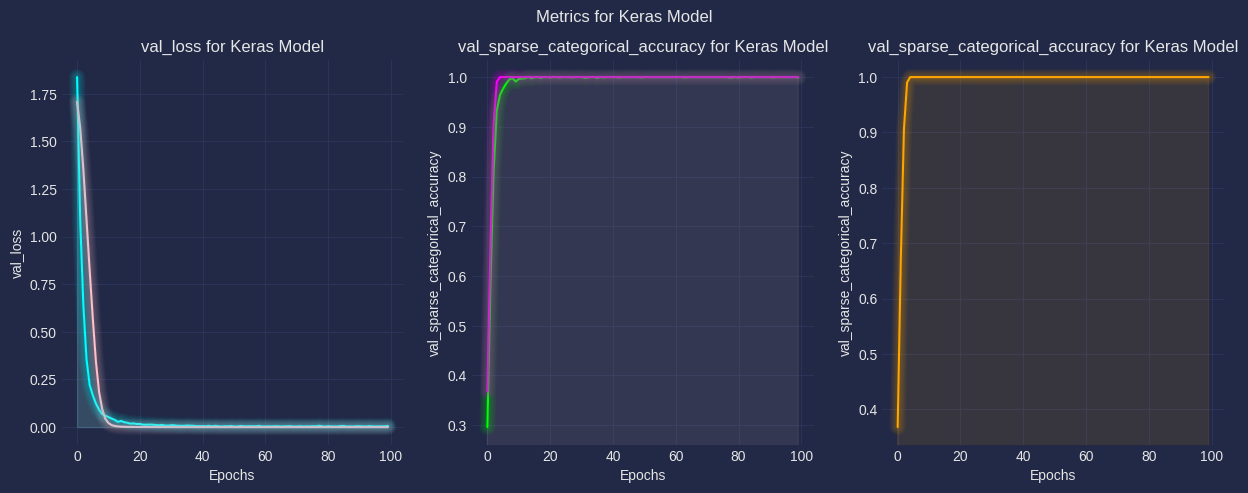

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle(f'Metrics for Keras Model')

def plot_keras_metric(ax, idx, hist, metric, color):
    ax[idx].set_title(f'{metric} for Keras Model')
    ax[idx].set_xlabel(f'Epochs')
    ax[idx].set_ylabel(f'{metric}')
    ax[idx].plot(hist[metric], color=color)
    ax[idx].legend()

plot_keras_metric(ax, 0, history.history, 'loss', 'cyan')
plot_keras_metric(ax, 0, history.history, 'val_loss', 'pink')
plot_keras_metric(ax, 1, history.history, 'sparse_categorical_accuracy', 'lime')
plot_keras_metric(ax, 1, history.history, 'val_sparse_categorical_accuracy', 'magenta')
plot_keras_metric(ax, 2, history.history, 'val_sparse_categorical_accuracy', 'orange')

for i in range(3):
    mplcyberpunk.make_lines_glow(ax=ax[i])
    mplcyberpunk.add_underglow(ax=ax[i])

In [12]:
evals = model.evaluate(x_test, y_test)
preds = np.argmax(model.predict(x_test), axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3823e-05 - sparse_categorical_accuracy: 1.0000 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [13]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        68
           4       1.00      1.00      1.00        59
           5       1.00      1.00      1.00        73

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388



<Axes: title={'center': 'Confusion Matrix for Keras Model Predictions'}>

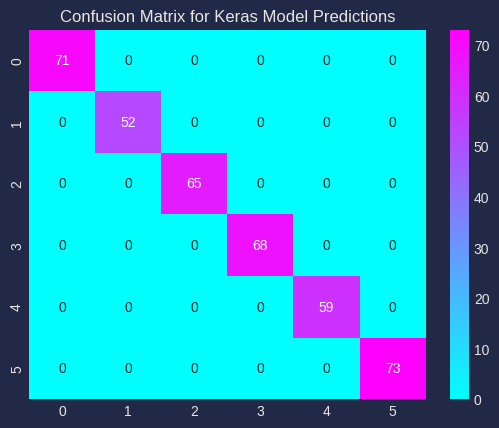

In [14]:
cm = confusion_matrix(y_test, preds)

plt.title('Confusion Matrix for Keras Model Predictions')
sns.heatmap(cm, annot=True, fmt='d', cmap='cool')